# Import packages

In [7]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras import regularizers, layers

from collections import defaultdict
from tqdm import tqdm

# Setup datasets

In [8]:
IMG_SIZE = 224
USE_AUGUMENTATION = False
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 16
EPOCHS = 60

In [9]:
dataset_name = "brain-mri"
dataset_paths = [
    '/kaggle/input/brain-mri-224x224/Training',
    '/kaggle/input/brain-mri-224x224/Testing'
]

In [10]:
classes = [
    'notumor', 
    'glioma', 
    'pituitary', 
    'meningioma'
]
num_classes = len(classes)
classes

['notumor', 'glioma', 'pituitary', 'meningioma']

In [11]:
data_dict = defaultdict(list)
error_count = 0
image_paths = []
images = []
labels = []

limit = 2000

for path in dataset_paths:
    for dirpath, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            label = dirpath.split('/')[-1]
            if label not in classes: continue
            if len(data_dict[label]) >= limit: continue
            try:
                path = os.path.join(dirpath, filename)
                image = cv2.imread(path) # Check for no error
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                data_dict[label].append(image)
                image_paths.append(path)
                images.append(image)
                labels.append(label)
            except:
#                 print('ERROR: ', filename)
                error_count += 1

print("ErrorCount:", error_count)
print("Total Images:", len(images))

0it [00:00, ?it/s]
100%|██████████| 1321/1321 [00:10<00:00, 125.22it/s]
0it [00:00, ?it/s]
100%|██████████| 300/300 [00:02<00:00, 125.64it/s]

ErrorCount: 0
Total Images: 7023


Text(0.5, 0, '')

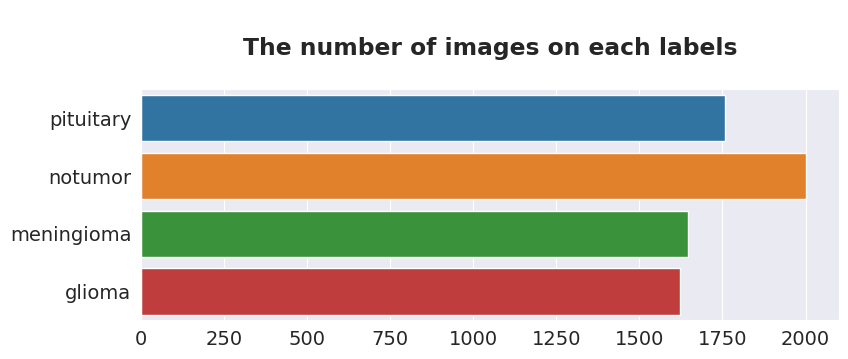

In [14]:
plt.figure(figsize=(9, 3))
sns.countplot(y=pd.Series(labels))
plt.title("\nThe number of images on each labels\n", weight="bold")
plt.xlabel("")

In [ ]:
plt.rcParams.update({'font.size': 14})

def visualize_datasets(images, labels, k=4, cols=4, seed=42):
    # visualize datasets

    if k > len(images): k = len(images)
    rows = int(np.ceil(k / cols))
    fig = plt.figure(figsize=(6 * cols, 4 * rows))

    for i in range(k):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.title.set_text(labels[i])
        plt.imshow(images[i])
        plt.colorbar()
        plt.axis('off')

    plt.show()

sample_images = [data_dict[k][0] for k in data_dict]
visualize_datasets(sample_images, list(data_dict.keys()), k=len(data_dict), cols=4)

# Encode datasets

In [16]:
# Convert labels to numpy array
x = np.stack(images, axis=0)
y = tf.one_hot([classes.index(label) for label in labels], num_classes).numpy()

x.shape, y.shape

((7023, 224, 224, 3), (7023, 4))

# Split datasets

In [17]:
# Split the data into training and remaining sets (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

[
    x_train.shape, 
    x_val.shape, 
    x_test.shape, 
    y_train.shape , 
    y_val.shape , 
    y_test.shape
]

[(5618, 224, 224, 3),
 (702, 224, 224, 3),
 (703, 224, 224, 3),
 (5618, 4),
 (702, 4),
 (703, 4)]

# Helper functions

In [18]:
def plot_acc(model_history, name):
    plt.rcParams.update({'font.size': 14})
    print('\n\n')
    epochs = len(model_history.history["accuracy"])
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc", marker="o")
    plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc", marker="o")
    plt.title("Training Accuracy - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [19]:
def plot_loss(model_history, name):
    plt.rcParams.update({'font.size': 14})
    print('\n\n')
    epochs = len(model_history.history["loss"])
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", marker="o")
    plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss", marker="o")
    plt.title("Training Loss - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [20]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams.update({'font.size': 14})
    
    # plot the confusion matrix
    class_count = len(classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [21]:
def evaluate(model, x, y):
    scores = model.evaluate(x, y, verbose=1)
    return scores

In [22]:
def predict_prob(model):
    return model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

In [23]:
def predict(model):
    predictions = predict_prob(model)
    return np.argmax(predictions, axis=1)

In [24]:
def calculate_metrics(y_true, y_pred):
    
    print("Visualize: y_true, y_pred top 20")
    print('Y_true', [i for i in y_true[:20]])
    print('Y_pred', [j for j in y_pred[:20]])

    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision: {}".format(precision))

    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:    {}".format(recall))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1:        {}".format(f1))

# Setup Training

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=1)

In [26]:
def transfer_learning(model, name):
    
    best_weights_ph1 = f"{dataset_name}_{name}_ph1_weights.keras"
    
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph1,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint, early_stop]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx + 1))
    
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('\nRestoring best weights and predicting validation set.')
    model.load_weights(best_weights_ph1)
    model.save(f"{dataset_name}_{name}_ph1_model.keras")
    
    loss, acc = evaluate(model, x_test, y_test)
    print('Transfer Learning test scores (loss, acc):', [loss, acc])
    plot_acc(history, f"\n Transfer Learning - ACC: {name} PhA.")
    plot_loss(history, f"\n Transfer Learning - LOSS: {name} PhA.")
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

# Setup fine tuning

In [27]:
def fine_turning(model, name, acc_ph1):
    
    best_weights_ph2 = f"{dataset_name}_{name}_ph2_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph2,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        x_train, 
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint, early_stop, lr_callback]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx))
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('Restoring best weights of Ph2 and predicting test set.')
    model.load_weights(best_weights_ph2)
    model.save(f"{dataset_name}_{name}_ph2_model.keras")
    
    loss, acc = evaluate(model, x_test, y_test)
    print('Fine Tuning test scores (loss, acc):', [loss, acc])
    
    if val_acc_max < acc_ph1:
        print('\nPhase 2 resulted in lower accuracy than Phase 1.')
    
    plot_acc(history, f"\n Fine Tuning - ACC: {name} PhB.")
    plot_loss(history, f"\n Fine Tuning - LOSS: {name} PhB.")
    
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

# Setup save history

In [28]:
def save_history(history, path):
    history_df = pd.DataFrame(data=history)
    history_df.index.name = "Epoch"
    history_df.to_csv(path)
    print("Saved history completed.")
    print(history_df)

# Build Model

# Define Model Holder

In [29]:
class ExpModel:
    
    priority = 0
    
    def __init__(self, model, name, pretrained=True, priority=None, is_ready=True):
        
        self.model = model
        self.name = name
        self.pretrained = pretrained
        self.priority = priority
        if self.priority is None:
            ExpModel.priority += 1
            self.priority = ExpModel.priority
        self.is_ready = is_ready

exp_models = dict()

# Custom Model

In [30]:
def data_augumentation_layer():
    
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02, fill_mode='constant'),
        layers.RandomContrast(0.1),
        layers.RandomZoom(height_factor=0.01, width_factor=0.05),
        layers.RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
    ], name="augumentation_layer")

def build_model():
    
    x_input = tf.keras.Input(shape=INPUT_SHAPE)
    
    s1 = layers.Rescaling(1 / 255.0)(x_input)
    a1 = data_augumentation_layer()(s1)
    
    c1 = layers.Conv2D(64, (5, 5), activation="relu")(a1)
    p1 = layers.MaxPooling2D(pool_size=(3, 3))(c1)
    
    c2 = layers.Conv2D(64, (5, 5), activation="relu")(p1)
    p2 = layers.MaxPooling2D(pool_size=(3, 3))(c2)
    
    c3 = layers.Conv2D(128, (4, 4), activation="relu")(p2)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = layers.Conv2D(128, (4, 4), activation="relu")(p3)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    f1 = layers.Flatten()(p4)
    
    d1 = layers.Dense(512, activation="relu")(f1)
    output = layers.Dense(num_classes, activation="softmax")(d1)
    
    return tf.keras.Model(x_input, output, name='ProposedModel')

model = build_model()
exp_models['Proposed Model'] = ExpModel(model, 'Proposed Model', pretrained=False, is_ready=True)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")
model.summary()

ProposedModel: 14 layers. 1.09M params.
Model: "ProposedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 augumentation_layer (Seque  (None, 224, 224, 3)       0         
 ntial)                                                          
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Co

# EfficientNetB3

In [31]:
pretrained = tf.keras.applications.EfficientNetB3(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='EfficientNetB3')

model = build_model()
exp_models['EfficientNetB3'] = ExpModel(model, 'EfficientNetB3', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

43941136/43941136 [==============================] - 2s 0us/step
EfficientNetB3: 391 layers. 12.37M params.


# ResNet50

In [32]:
pretrained = tf.keras.applications.ResNet50(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='ResNet50')

model = build_model()
exp_models['ResNet50'] = ExpModel(model, 'ResNet50', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

94765736/94765736 [==============================] - 4s 0us/step
ResNet50: 177 layers. 23.60M params.


# DenseNet169

In [33]:
pretrained = tf.keras.applications.DenseNet169(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='DenseNet169')

model = build_model()
exp_models['DenseNet169'] = ExpModel(model, 'DenseNet169', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

51877672/51877672 [==============================] - 3s 0us/step
DenseNet169: 597 layers. 12.65M params.


# Xception

In [34]:
pretrained = tf.keras.applications.Xception(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='Xception')

model = build_model()
exp_models['Xception'] = ExpModel(model, 'Xception', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

83683744/83683744 [==============================] - 3s 0us/step
Xception: 134 layers. 20.87M params.


# MobileNet

In [35]:
pretrained = tf.keras.applications.MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='MobileNet')

model = build_model()
exp_models['MobileNet'] = ExpModel(model, 'MobileNet', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")


17225924/17225924 [==============================] - 1s 0us/step
MobileNet: 88 layers. 3.23M params.


# Train



 ==========Start Process with model Proposed Model=========
Epoch 1/60


I0000 00:00:1713453264.100166     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.5881
Epoch 1: val_accuracy improved from -inf to 0.74074, saving model to brain-mri_Proposed Model_ph2_weights.keras
352/352 [==============================] - 15s 24ms/step - loss: 0.9416 - accuracy: 0.5881 - val_loss: 0.6202 - val_accuracy: 0.7407
Epoch 2/60
352/352 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7841
Epoch 2: val_accuracy improved from 0.74074 to 0.80912, saving model to brain-mri_Proposed Model_ph2_weights.keras
352/352 [==============================] - 7s 21ms/step - loss: 0.5526 - accuracy: 0.7841 - val_loss: 0.4476 - val_accuracy: 0.8091
Epoch 3/60
351/352 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8490
Epoch 3: val_accuracy did not improve from 0.80912
352/352 [==============================] - 7s 21ms/step - loss: 0.4000 - accuracy: 0.8491 - val_loss: 0.6868 - val_accuracy: 0.7479
Epoch 4/60
351/352 [============================

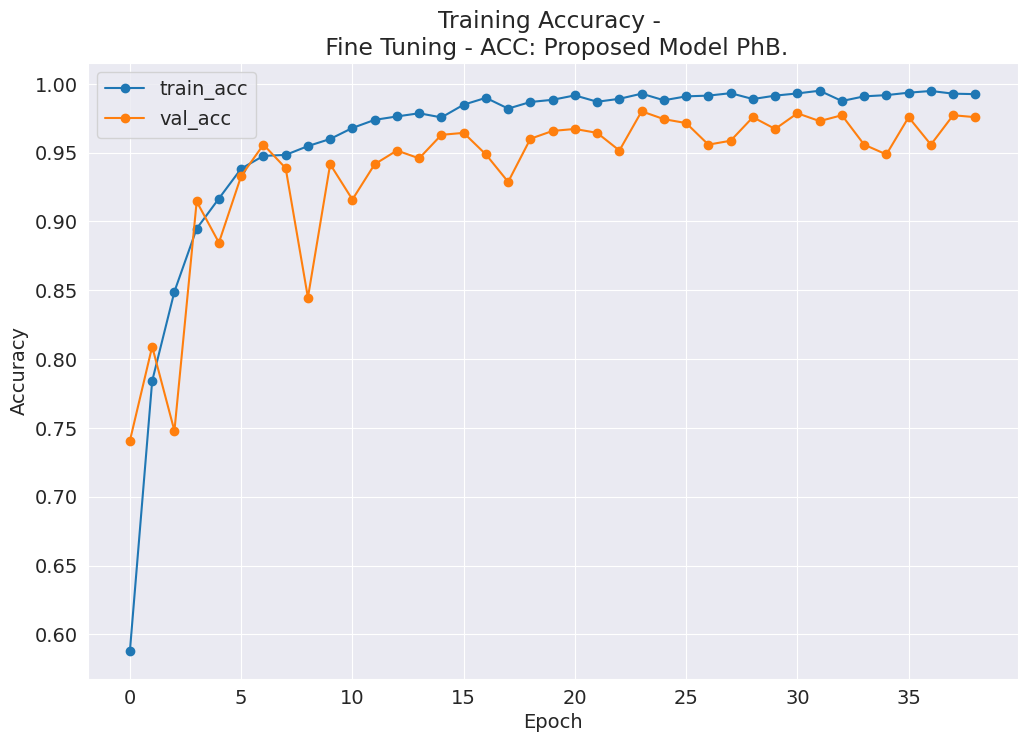

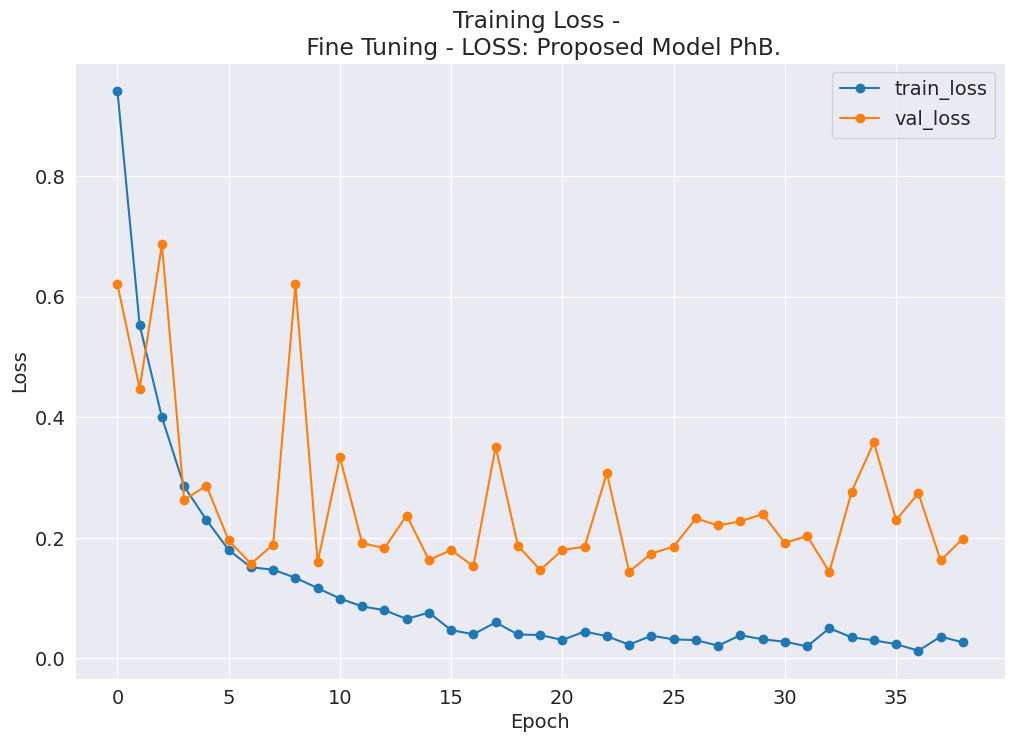

44/44 [==============================] - 1s 12ms/step
Visualize: y_true, y_pred top 20
Y_true [0, 1, 3, 1, 0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 0]
Y_pred [0, 1, 3, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 0]
Precision: 0.976061535558613
Recall:    0.9758179231863442
F1:        0.9758654298053687


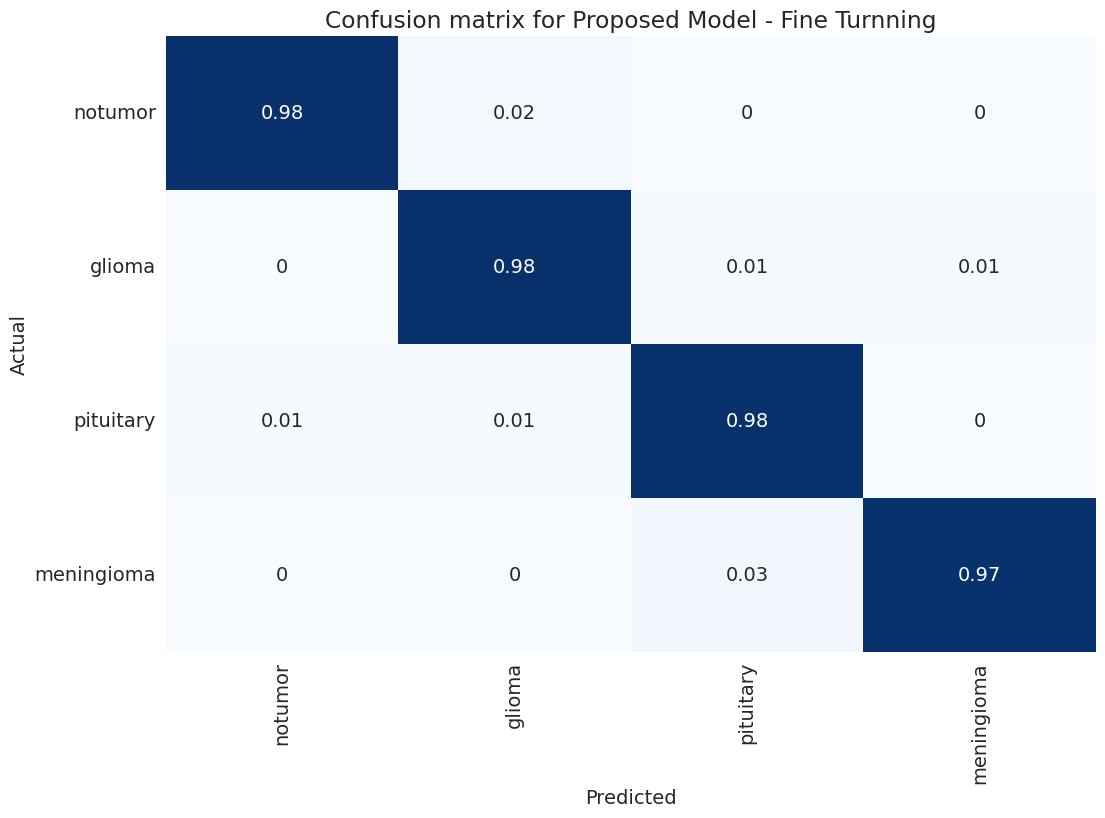

Saved history completed.
           loss  accuracy  val_loss  val_accuracy
Epoch                                            
0      0.941604  0.588110  0.620237      0.740741
1      0.552606  0.784087  0.447598      0.809117
2      0.399995  0.849057  0.686801      0.747863
3      0.285165  0.894802  0.262862      0.914530
4      0.229731  0.916696  0.286565      0.884615
5      0.179826  0.938412  0.195670      0.933048
6      0.151134  0.947668  0.156962      0.955840
7      0.147169  0.948380  0.188811      0.938746
8      0.133808  0.954788  0.620215      0.844729
9      0.116521  0.959950  0.159340      0.941595
10     0.099332  0.967960  0.333685      0.915954
11     0.086190  0.973834  0.191236      0.941595
12     0.080026  0.976326  0.182869      0.951567
13     0.065410  0.978640  0.237003      0.945869
14     0.076074  0.975614  0.163470      0.962963
15     0.046890  0.984870  0.179607      0.964387
16     0.040026  0.989854  0.152923      0.948718
17     0.059805  0.982022

In [36]:
filtered_models = list(filter(lambda obj: obj.is_ready, sorted(exp_models.values(), key=lambda obj: obj.priority)))
expected_acc = 0.99
for current_model in filtered_models:
    
    best_acc = 0
    print(f'\n\n ==========Start Process with model {current_model.name}=========')
    if current_model.pretrained:
        history, model, best_acc, y_pred = transfer_learning(current_model.model, current_model.name)
        y_true = np.argmax(y_test, axis=1)
        calculate_metrics(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {current_model.name} - Transfer Learning")
        save_history(history.history, f"{current_model.name}-{dataset_name}-transfer-learning-results.csv")
    
    if best_acc < expected_acc:
        history, model, best_acc, y_pred = fine_turning(current_model.model, current_model.name, best_acc)
        y_true = np.argmax(y_test, axis=1)
        calculate_metrics(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {current_model.name} - Fine Turnning")
        save_history(history.history, f"{current_model.name}-{dataset_name}-fine-tuning-results.csv")
    
    print("Classification Report for {}".format(current_model.name))
    print(classification_report(y_true, y_pred, target_names=classes))
    
    
    
    print(f'\n\n ==========Completed Process with model {current_model.name}=========')

# Test and Visualize Results

In [37]:
k = 5
n = len(y_test)
sample_idx = np.random.choice(range(n), k)
x_sample = x_test[sample_idx]
y_sample = y_test[sample_idx]
y_sample

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
plt.rcParams.update({'font.size': 16})

def format_label(label):
    return '\n'.join(label.split())

short_labels = list(map(format_label, classes))
for current_model in filtered_models:
    if not current_model.is_ready: continue
    model = current_model.model
    print("\n\nPrediction for {} model".format(current_model.name))
    y_pred = model.predict(x_sample)
    fig, ax = plt.subplots(k, 2, figsize=(30, 25))
    y_true = np.argmax(y_sample, axis=1)
    for i in range(k):
        acc = y_pred[i] * 100
        bar_colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray', 'magenta']
        ax[i, 0].imshow(x_sample[i] / 255)
        ax[i, 0].axis('off')
        ax[i, 1].bar(short_labels, acc, label=short_labels, color=[bar_colors[i % len(bar_colors)] for i in range(num_classes)])
        ax[i, 1].set_ylabel('Predict')
        ax[i, 1].set_title('Ground Truth: {}'.format(classes[y_true[i]]))

    plt.tight_layout()
    plt.show()



Prediction for Proposed Model model
1/1 [==============================] - 0s 177ms/step
